### Measuring Equity Risk

In this notebook we'll explore three statistical methods for calculating Equity Risk:

+ Variance: fluctuation of stock return from its mean
+ Beta: riskiness of a stock compared to the market
+ VaR: the maximum an investor could loose (within a confidence interval)

For the purposes of this notebook, we'll explore the above looking at the risk of Apple (ticker = AAPL).

In [30]:
# Import all the required packages
# The pandas_datareader library contains functions which allow us to call data from various internet sources
import pandas as pd
import quandl
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
plt.style.use('fivethirtyeight')
from statsmodels.formula.api import ols

# Use Python's "magic" commands since we want to see the graphs within this notebook
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Collecting and cleaning the data

In [31]:
# First, we need to collect our data
# Lets collect stock prices for AAPL using the QandL API
# Lets limit our sample to the last 1000 days of prices

quandl.ApiConfig.api_key = "U4JsbXnxqewAQH5ACxAa" # Password has been  changed before publishing this notebook
aapl = quandl.get_table('WIKI/PRICES', ticker='AAPL')
aapl = aapl[['date','adj_close']][-1000:]
aapl = aapl.set_index("date")
aapl["aapl_returns"] = aapl['adj_close'].pct_change()
aapl = aapl.dropna(axis=0) 

In [32]:
## Lets check the data looks OK?

aapl.tail(2)

,adj_close,aapl_returns
date,,
2018-02-26,178.97,0.019453
2018-02-27,178.39,-0.003241


In [33]:
# For demonstration purposes, lets collect S&P returns using a CSV file (rather than the API above)
# Note: the csv file below is saved locally

path = "C:/Users/Stephen/Documents/Juypter/Portfolio/data/snp500.csv"
snp = pd.read_csv(path, parse_dates=True, index_col='Date')
snp = snp[["Adj Close"]]
snp["snp_returns"] = snp["Adj Close"].pct_change(1)
snp = snp.dropna(axis=0) 

In [34]:
# Join the AAPL and SnP data into one DataFrame

data = aapl.join(snp)
data = data[["snp_returns","aapl_returns"]]
data = data.dropna()

In [35]:
# Eyeball the new DataFrame
# Results look good! 

data.tail(2)

,snp_returns,aapl_returns
date,,
2018-02-21,-0.005497,-0.004539
2018-02-22,0.000974,0.008944


#### Stock Variance

First, lets check the summary statistics for both AAPL and the S&P Index. We can also plot the returns as a histogram to get an idea of dispersion of returns.

In [36]:
# Here we can see AAPL has a mean return of around 0.11% with standard deviation 1.4%
# The minimum return was -6.5% and the max 8.2%

aapl_summary = data["aapl_returns"].describe()
aapl_summary

count    873.000000
mean       0.001112
std        0.013946
min       -0.065707
25%       -0.005618
50%        0.000893
75%        0.008637
max        0.081982
Name: aapl_returns, dtype: float64

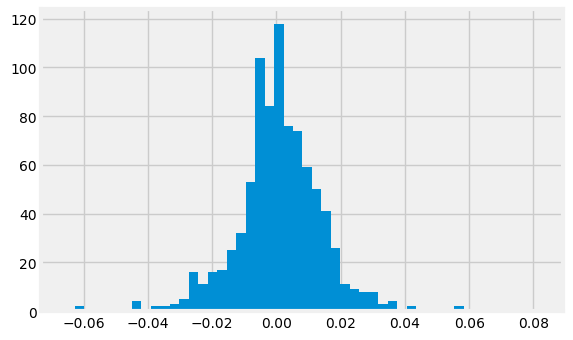

In [37]:
# Lets now plot the distribution of returns using our favourite "FiveThirtyEight" styled histogram

data["aapl_returns"].hist(bins=50, figsize=(6,4))

In [38]:
data.head(1)

,snp_returns,aapl_returns
date,,
2014-03-10,0.011166,0.000905


In [39]:
# There are some outliers
# Lets check on what date AAPL had a min and max return

max_date = data.loc[data['aapl_returns'].idxmax()].name.date()
min_date = data.loc[data['aapl_returns'].idxmin()].name.date()

print "The max value for aapl was recorded on {} while the min value was recorded on {}".format(max_date, min_date)

The max value for aapl was recorded on 2014-04-24 while the min value was recorded on 2016-01-27


In [40]:
# Now, lets do the same for the S&P returns, and plot them side by side

snp_summary = data["snp_returns"].describe()
snp_summary 

count    873.000000
mean       0.000420
std        0.007672
min       -0.039414
25%       -0.002740
50%        0.000419
75%        0.004457
max        0.039034
Name: snp_returns, dtype: float64

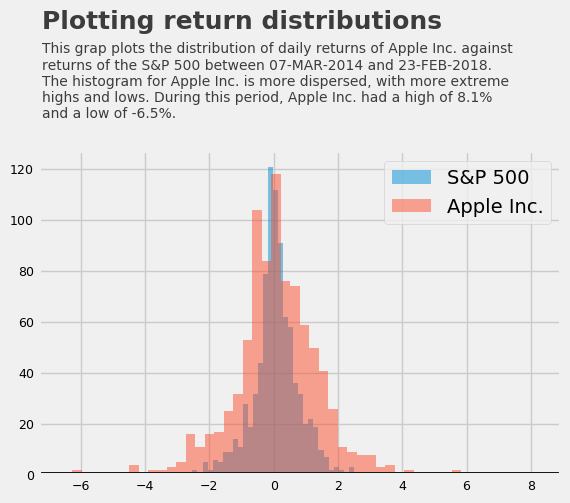

In [41]:
style.use('fivethirtyeight')

x = data["snp_returns"] * 100
y = data["aapl_returns"] * 100

plt.hist(x, alpha = 0.5, bins=50, label='S&P 500')
plt.hist(y,alpha = 0.5, bins = 50, label='Apple Inc.')
plt.legend(loc='upper right')
plt.tick_params(axis = 'both', which = 'major', labelsize = 9)
plt.axhline(y = 0, color = 'black', linewidth = 5, alpha = 1)
#plt.xlabel(s = "% return", fontsize = "small")

plt.text(-7.2, 140, s = """This grap plots the distribution of daily returns of Apple Inc. against 
returns of the S&P 500 between 07-MAR-2014 and 23-FEB-2018. 
The histogram for Apple Inc. is more dispersed, with more extreme 
highs and lows. During this period, Apple Inc. had a high of 8.1%
and a low of -6.5%.""", fontsize = 10, alpha = .75)

plt.text(-7.2, 175, s = """Plotting return distributions""", weight = "bold", fontsize = 18, alpha = .75)
plt.show()

#### Value at Risk (VaR)

In [42]:
from scipy.stats import norm

def var_cov_var(P, c, m, sigma):
    """
    Variance-Covariance calculation of daily Value-at-Risk
    using confidence level c, with mean of returns m
    and standard deviation of returns sigma, on a portfolio
    of value P.
    """
    alpha = norm.ppf(1-c, m, sigma)
    return P - P*(alpha + 1)

P = 1000000   # 1,000,000 USD
c = 0.99  # 99% confidence interval

aapl_mean = data["aapl_returns"].mean()
aapl_sigma = data["aapl_returns"].std()

snp_mean = data["snp_returns"].mean()
snp_sigma = data["snp_returns"].std()

var_aapl = var_cov_var(P, c, aapl_mean, aapl_sigma)
var_snp = var_cov_var(P, c, snp_mean, snp_sigma)

print "The one day VaR for Apple on a $1 million portfolio is ${:,.2f}".format(round(var_aapl,2))
print "The one day VaR for the S&P 500 on a $1 million portfolio is ${:,.2f}".format(round(var_snp,2))

The one day VaR for Apple on a $1 million portfolio is $31,330.03
The one day VaR for the S&P 500 on a $1 million portfolio is $17,427.80


#### Beta

In [43]:
path = "C:/Users/Stephen/Documents/Juypter/Portfolio/data/monthly.csv"
monthly = pd.read_csv(path, parse_dates=True, index_col='Date')
monthly["snp_returns"] = monthly["snp"].pct_change(1)
monthly["aapl_returns"] = monthly["aapl"].pct_change(1)
monthly = monthly.dropna(axis=0) 

In [44]:
import statsmodels.api as sm

# split dependent and independent variable
X = monthly["snp_returns"]
y = monthly["aapl_returns"]

# Add a constant to the independent value
X1 = sm.add_constant(X)

# make regression model 
model = sm.OLS(y, X1)

# fit model and print results
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           aapl_returns   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     24.07
Date:                Wed, 28 Feb 2018   Prob (F-statistic):           7.88e-06
Time:                        20:34:21   Log-Likelihood:                 90.792
No. Observations:                  60   AIC:                            -177.6
Df Residuals:                      58   BIC:                            -173.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0119      0.007      1.602      